# PINN Solution of the Gray Scott PDEs

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Gray Scott PDEs with periodic boundary condition
\begin{aligned}
  &u_t = \epsilon_1\Delta u + b(1 - u) - uv^2, \quad (t, x) \in [0, T]\times[0, L]\\
  &v_t = \epsilon_2\Delta v - dv + uv^2, \\
  &u(0, x) = u_0(x), \quad v(0, x) = v_0(x), \quad \forall x \in [0, L] \\
  &u(t, 0) = u(t, L) = u_s, \quad v(t, 0) = v(t, L) = v_s, \quad \forall t \in [0, T]
\end{aligned}
where $\epsilon_1, \epsilon_2, b, d > 0$ are some parameters, and $[x_{\min}, x_{\max}]$ covers one full period.

See [this link](https://www.chebfun.org/examples/pde/GrayScott.html) for a description

## Libraries and Dependencies

In [1]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# set the random seed
np.random.seed(1234)

In [2]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean       # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": r"\usepackage[utf8x]{inputenc} \usepackage[T1]{fontenc}"
    # use utf8 fonts becasue your computer can handle it :)
    # plots will be generated using this preamble
    }
mpl.rcParams.update(pgf_with_latex)

In [4]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [5]:
"""
Problem Definition
"""
# define grid for quadrature solution
epsilon1 = 1e-2
epsilon2 = 1e-2
F = 0.09
K = -0.004
b = F
d = F + K
L = 2.0
xlo = 0.0
xhi = L
tlo = 0.0
thi = 3.0
u_s = 1.0
v_s = 0.0
u0 = lambda x: u_s + 0.01 * np.sin(np.pi * x/L)
v0 = lambda x: v_s - 0.12 * np.sin(np.pi * x/L)
# we need to prepare the true solution from chebfun 

## Physics-informed Neural Networks

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_IC, u_IC, v_IC, X_BC, u_BC, v_BC, X_pde, layers, epsilon1, epsilon2, b, d):
        # Initial Condition points
        self.t_IC = torch.tensor(X_IC[:, 0:1]).float().to(device)
        self.x_IC = torch.tensor(X_IC[:, 1:2]).float().to(device)
        self.u_IC = torch.tensor(u_IC).float().to(device)
        self.v_IC = torch.tensor(v_IC).float().to(device)    
        # Boundary (Left and right) Condition points
        self.t_BC = torch.tensor(X_BC[:, 0:1]).float().to(device)
        self.x_BC = torch.tensor(X_BC[:, 1:2]).float().to(device)
        self.u_BC = torch.tensor(u_BC).float().to(device)
        self.v_BC = torch.tensor(v_BC).float().to(device)         
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_pde = torch.tensor(X_pde[:, 0:1], requires_grad=True).float().to(device)
        self.x_pde = torch.tensor(X_pde[:, 1:2], requires_grad=True).float().to(device)
        # equation related parameters
        self.epsilon1 = epsilon1
        self.epsilon2 = epsilon2
        self.b = b
        self.d = d
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        self.Adam_tol = 1e-2
        self.iter = 0
    # evaluater neural network
    def NN_eval(self, t, x):  
        NN = self.dnn(torch.cat([t, x], dim = 1)) 
        u = NN[:, 0][:, None]
        v = NN[:, 1][:, None]
        return u, v
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u, v = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t = torch.autograd.grad(u, t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        Eq1 = u_t - self.epsilon1 * u_xx - self.b * (1.0 - u) + u * torch.pow(v, 2.0)
        Eq2 = v_t - self.epsilon2 * v_xx + self.d * v - u * torch.pow(v, 2.0)
        return Eq1, Eq2
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer.zero_grad()
        # compute the IC loss
        uIC_pred, vIC_pred = self.NN_eval(self.t_IC, self.x_IC)
        loss_IC = torch.mean((self.u_IC - uIC_pred)**2.0) + torch.mean((self.v_IC - vIC_pred)**2.0)
        # compute the IC loss
        uBC_pred, vBC_pred = self.NN_eval(self.t_BC, self.x_BC)
        loss_BC = torch.mean((self.u_BC - uBC_pred)**2.0) + torch.mean((self.v_BC - vBC_pred)**2.0)
        # compute PDE loss
        pde1_pred, pde2_pred = self.pde_eval(self.t_pde, self.x_pde)
        loss_pde = torch.mean(pde1_pred ** 2) + torch.mean(pde2_pred ** 2)
        # compute the total loss, it can be weighted
        loss = loss_IC + loss_BC + loss_pde
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        if (self.iter + 1) % 1000 == 0:
            print(
                'Iter %5d, Total: %10.4e, IC: %10.4e, BC: %10.4e, PDE: %10.4e' 
                % (self.iter + 1, loss.item(), loss_IC.item(), loss_BC.item(), loss_pde.item())
            )        
        return loss
    #
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            # compute the IC loss
            uIC_pred, vIC_pred = self.NN_eval(self.t_IC, self.x_IC)
            loss_IC = torch.mean((self.u_IC - uIC_pred)**2.0) + torch.mean((self.v_IC - vIC_pred)**2.0)
            # compute the IC loss
            uBC_pred, vBC_pred = self.NN_eval(self.t_BC, self.x_BC)
            loss_BC = torch.mean((self.u_BC - uBC_pred)**2.0) + torch.mean((self.v_BC - vBC_pred)**2.0)
            # compute PDE loss
            pde1_pred, pde2_pred = self.pde_eval(self.t_pde, self.x_pde)
            loss_pde = torch.mean(pde1_pred ** 2) + torch.mean(pde2_pred ** 2)
            # compute the total loss, it can be weighted
            loss = loss_IC + loss_BC + loss_pde
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            # output the progress
            if epoch == 0:
                loss_prev = loss.item()
            if (epoch + 1) % 1000 == 0:
                loss_curr = loss.item()
                print(
                    'Iter %5d, Total: %10.4e, IC: %10.4e, BC: %10.4e, PDE: %10.4e' 
                    % (epoch + 1, loss_curr, loss_IC.item(), loss_BC.item(), loss_pde.item())
                )          
                if (loss_prev != 0) and (np.abs(loss_curr - loss_prev)/loss_prev < self.Adam_tol):
                    print('Stopping at epoch = %5d' % (epoch))
                    break           
    #        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u, v

## Configurations

In [8]:
N_IC = 100
N_BC = 200
N_PDE = 1024
# where we know the data
# IC
# IC: t = 0, x \in [xlo, xhi], it can be on a gridd or random
# make sure they are all column vectors, which is a 2-dim tensor
xIC = np.expand_dims(np.linspace(xlo, xhi, N_IC), axis = 1)
tIC = np.zeros_like(xIC)
ptsIC = np.hstack((tIC, xIC))
uIC = u0(xIC)
vIC = v0(xIC)
# Left BC: x = xlo, t \in [0, T], it can be on a grid or random
tLBC = np.expand_dims(np.linspace(tlo, thi, int(N_BC/2)), axis = 1)
xLBC = xlo * np.ones_like(tLBC)
ptsLBC = np.hstack((tLBC, xLBC))
uLBC = u_s * np.ones_like(tLBC)
vLBC = v_s * np.ones_like(tLBC)
# Right BC: x = xhi, t \in [0, T], it can be on a grid or random
tRBC = np.expand_dims(np.linspace(tlo, thi, int(N_BC/2)), axis = 1)
xRBC = xhi * np.ones_like(tRBC)
ptsRBC = np.hstack((tRBC, xRBC))
uRBC = u_s * np.ones_like(tRBC)
vRBC = v_s * np.ones_like(tRBC)
# assemble the boundary points
ptsBC = np.vstack((ptsLBC, ptsRBC))
uBC = np.vstack((uLBC, uRBC))
vBC = np.vstack((vLBC, vRBC))
# collocation points for PDE loss
pts_PDE = lhs(2, N_PDE)
# transform it back to proper range
t_pde = tlo + (thi - tlo) * pts_PDE[:, 0:1]
x_pde = xlo + (xhi - xlo) * pts_PDE[:, 1:2]
pts_PDE = np.hstack((t_pde, x_pde))

## Training

In [9]:
layers = [2, 20, 20, 20, 20, 2]
model = PhysicsInformedNN(ptsIC, uIC, vIC, ptsBC, uBC, vBC, pts_PDE, layers, epsilon1, epsilon2, b, d)

In [10]:
%%time
model.train(50000)

Iter  1000, Total: 5.9259e-04, IC: 3.2179e-04, BC: 1.1271e-04, PDE: 1.5809e-04
Iter  2000, Total: 6.9365e-05, IC: 2.4122e-05, BC: 8.6095e-06, PDE: 3.6633e-05
Iter  3000, Total: 3.8986e-05, IC: 1.3557e-05, BC: 4.1283e-06, PDE: 2.1301e-05
Iter  4000, Total: 1.9731e-05, IC: 6.7278e-06, BC: 1.8911e-06, PDE: 1.1112e-05
Iter  5000, Total: 9.6903e-06, IC: 3.0071e-06, BC: 9.7749e-07, PDE: 5.7056e-06
Iter  6000, Total: 5.5707e-06, IC: 1.1877e-06, BC: 6.2789e-07, PDE: 3.7552e-06
Iter  7000, Total: 9.1725e-06, IC: 2.7816e-06, BC: 3.3446e-06, PDE: 3.0463e-06
Iter  8000, Total: 4.5434e-06, IC: 1.0556e-06, BC: 1.1589e-06, PDE: 2.3289e-06
Iter  9000, Total: 2.6036e-06, IC: 3.8299e-07, BC: 3.3521e-07, PDE: 1.8854e-06
Iter 10000, Total: 2.4991e-06, IC: 5.5787e-07, BC: 4.4062e-07, PDE: 1.5006e-06
Iter 11000, Total: 1.0371e-05, IC: 4.0158e-06, BC: 4.9319e-06, PDE: 1.4231e-06
Iter 12000, Total: 1.2354e-06, IC: 1.2776e-07, BC: 9.5294e-08, PDE: 1.0123e-06
Iter 13000, Total: 1.1082e-06, IC: 1.3193e-07, BC: 7

KeyboardInterrupt: 

In [13]:
# apply PINN to the same grid as the quadrature solution for comparison
t = np.linspace(tlo, thi, 101)
x = np.linspace(xlo, xhi, 101)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_NN, v_NN = model.predict(pts_flat)
# #
# Exact = u_quad.T
# Exact_vec = Exact.flatten()[:, None]
# error_u = np.linalg.norm(Exact_vec-u_pred,2)/np.linalg.norm(Exact_vec,2)
# print('Error u: %e' % (error_u))                     
u_pred = griddata(pts_flat, u_NN.flatten(), (T, X), method='cubic')
v_pred = griddata(pts_flat, v_NN.flatten(), (T, X), method='cubic')
# Error = np.abs(Exact - U_pred)

## Visualizations

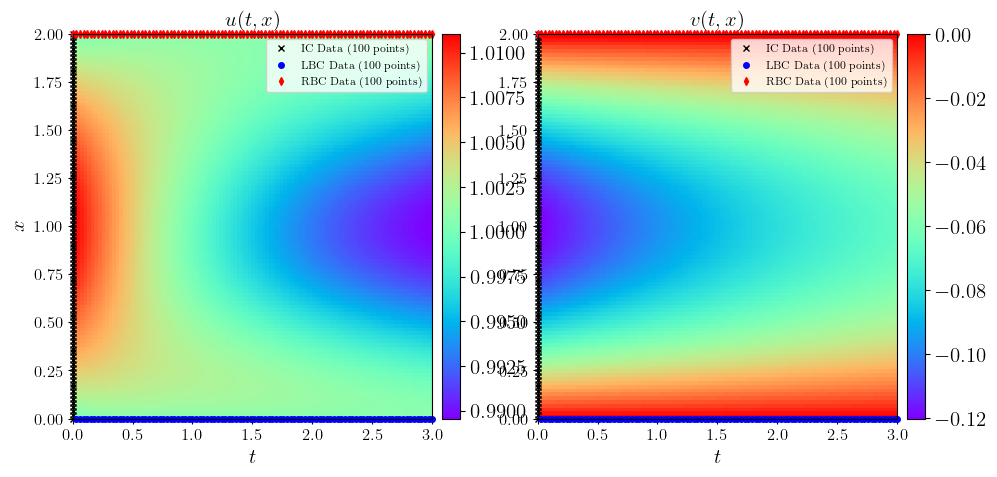

In [19]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(1, 2, 1)

h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(ptsIC[:, 0], ptsIC[:, 1], 
    'kx', label = 'IC Data (%d points)' % (ptsIC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsBC[1 : int(N_BC/2), 0], ptsBC[1 : int(N_BC/2), 1], 
    'bo', label = 'LBC Data (%d points)' % (int(N_BC/2)), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsBC[int(N_BC/2):, 0], ptsBC[int(N_BC/2):, 1], 
    'rd', label = 'RBC Data (%d points)' % (int(N_BC/2)), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.set_xlabel('$t$', size=15)
ax.set_ylabel('$x$', size=15)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.legend()
ax.set_title('$u(t,x)$', fontsize = 15) # font size doubled
ax.tick_params(labelsize=12)

ax = fig.add_subplot(1, 2, 2)

h = ax.imshow(v_pred, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(ptsIC[:, 0], ptsIC[:, 1], 
    'kx', label = 'IC Data (%d points)' % (ptsIC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsBC[1 : int(N_BC/2), 0], ptsBC[1 : int(N_BC/2), 1], 
    'bo', label = 'LBC Data (%d points)' % (int(N_BC/2)), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsBC[int(N_BC/2):, 0], ptsBC[int(N_BC/2):, 1], 
    'rd', label = 'RBC Data (%d points)' % (int(N_BC/2)), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.set_xlabel('$t$', size=15)
# ax.set_ylabel('$x$', size=15)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.legend()
ax.set_title('$v(t,x)$', fontsize = 15) # font size doubled
ax.tick_params(labelsize=12)


plt.show()

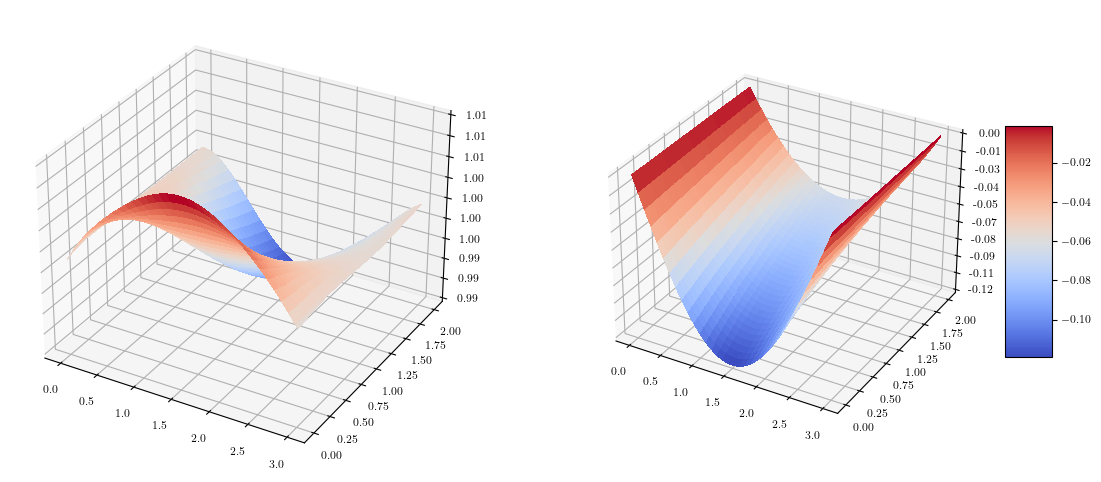

In [31]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Plot the surface.
surf = ax.plot_surface(T, X, u_pred.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Plot the surface.
surf = ax.plot_surface(T, X, v_pred.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

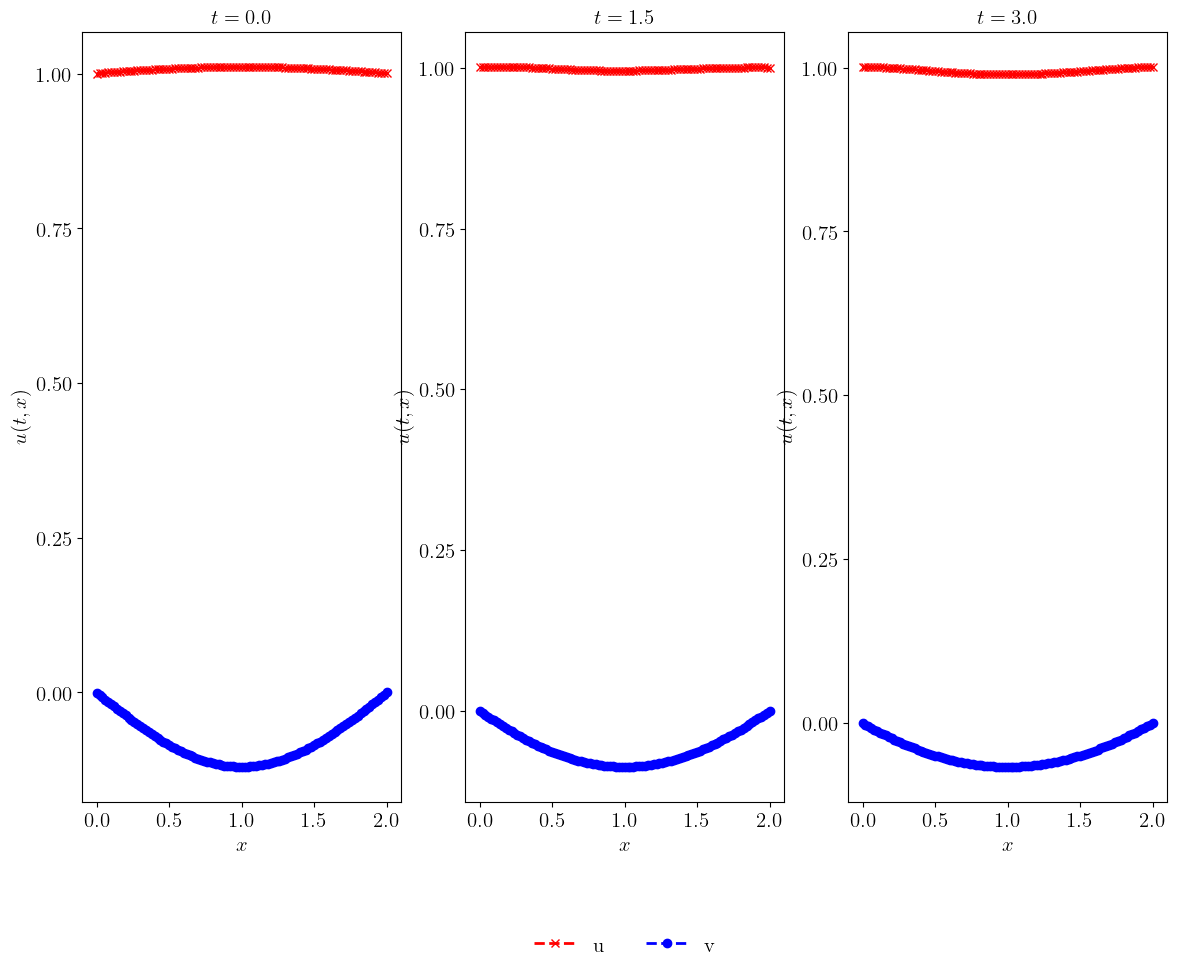

In [20]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
#
ax = plt.subplot(1, 3, 1)
#ax.plot(x, Exact[:, 25], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.plot(x, v_pred[:, 0], 'bo--', linewidth = 2, label = 'v')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 15)
#ax.axis('square')
#ax.set_xlim([-1.1,1.1])
#ax.set_ylim([-1.1,1.1])
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 2)
#ax.plot(x,Exact[:,50], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 50], 'rx--', linewidth = 2, label = 'u')
ax.plot(x, v_pred[:, 50], 'bo--', linewidth = 2, label = 'v')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
#ax.axis('square')
#ax.set_xlim([-1.1,1.1])
#ax.set_ylim([-1.1,1.1])
ax.set_title('$t = %.1f$' %(t[50]), fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 3)
#ax.plot(x,Exact[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')
ax.plot(x, v_pred[:, 100], 'bo--', linewidth = 2, label = 'v')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
#ax.axis('square')
#ax.set_xlim([-1.1,1.1])
#ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = %.1f$' %(t[100]), fontsize = 15)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()